In [5]:
import mne
import os
import glob
import numpy as np
import pandas as pd
from scipy.io import savemat, loadmat
import matplotlib.pyplot as plt
import pickle

from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs

import sys
sys.path.append('../utils')
from pp_utils import *
from plot_utils import *

## Choose subject and file

In [6]:
task = 'motor'
period = 'post'  
subjects_to_process = ['21']
#bad_ch_sub =  ['PO7', 'O1', 'Iz', 'P8', 'P10', 'TP8']

overwrite = False
keystroke_trigs = 'MIDI'
erp_begin = -0.5
erp_end = 0.5
erp_window = 'n05to05'


In [7]:
#======================================================================================
#                        INITIALIZE DIRECTORIES
#======================================================================================
pp_dir = "/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_preprocessed" #where the preprocessed files are

evokeds_folder = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_{task}/{task}_ERP_data_{erp_window}'
epochs_folder = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_{task}/{task}_epochs_data_{erp_window}'


with open('../utils/ch_names.pkl', 'rb') as file:
    ch_names_all = pickle.load(file)

ch_names_64 = ch_names_all[0:64]
ch_names_72 = ch_names_all[0:72]

"""ref_names = ['M1', 'M2']
eog_names = ['EOG1', 'EOG2']"""

downfreq = 128

In [9]:
"""#======================================================================================
#                        PARAMETERS
#======================================================================================
for folder in sorted(os.listdir(pp_dir)):
    if folder not in subjects_to_process:
        continue
    sub_pp_dir = os.path.join(pp_dir, folder)
    data_path = glob.glob(os.path.join(sub_pp_dir, f'eeg_{task}_{period}_??.mat'))[0]

    subject_ID = data_path.split('.')[0][-2:]

    print('Opening', data_path.split('/')[-1])
    
    
    data = loadmat(data_path)
    eeg = data['trial_data']
    refs = data['trial_mastoids']
    all_electrodes = data['all_electrodes']
    events_sv = data['events']"""

"""  already_processed = []
    already_processed.append(subject_ID)"""


'  already_processed = []\n    already_processed.append(subject_ID)'

In [57]:
data = loadmat('/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_preprocessed_15Hz/12/eeg_listen_post_12.mat')
eeg = data['trial_data']
refs = data['trial_mastoids']
all_electrodes = data['all_electrodes']
events_sv = data['events']

In [58]:
#making raw object from .mat data
info = mne.create_info(ch_names=ch_names_72, sfreq = 128, ch_types='misc')
raw = mne.io.RawArray(all_electrodes, info = info)

#define channel types
raw.set_channel_types({name: 'eeg' for name in ch_names_72[0:64]})
raw.set_channel_types({name: 'eog' for name in ch_names_72[66:68]})

raw.set_montage('biosemi64')

Creating RawArray with float64 data, n_channels=72, n_times=85120
    Range : 0 ... 85119 =      0.000 ...   664.992 secs
Ready.


/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_42418/3214231580.py:6: RuntimeWarning: The unit for channel(s) AF3, AF4, AF7, AF8, AFz, C1, C2, C3, C4, C5, C6, CP1, CP2, CP3, CP4, CP5, CP6, CPz, Cz, F1, F2, F3, F4, F5, F6, F7, F8, FC1, FC2, FC3, FC4, FC5, FC6, FCz, FT7, FT8, Fp1, Fp2, Fpz, Fz, Iz, O1, O2, Oz, P1, P10, P2, P3, P4, P5, P6, P7, P8, P9, PO3, PO4, PO7, PO8, POz, Pz, T7, T8, TP7, TP8 has changed from NA to V.
  raw.set_channel_types({name: 'eeg' for name in ch_names_72[0:64]})
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_42418/3214231580.py:7: RuntimeWarning: The unit for channel(s) LO1, LO2 has changed from NA to V.
  raw.set_channel_types({name: 'eog' for name in ch_names_72[66:68]})


<RawArray | 72 x 85120 (665.0 s), ~46.8 MB, data loaded>

NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 16.000 (s)


/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


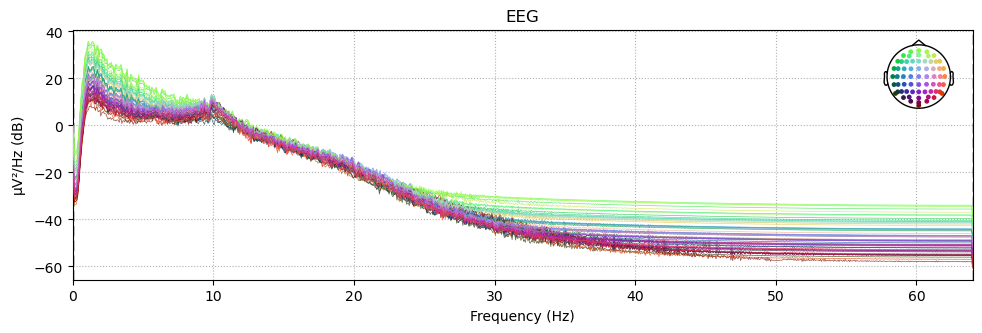

In [59]:
#raw.info['bads'] = bad_ch_sub
raw.info['bads'] = []
#check psd
mne.viz.plot_raw_psd(raw, fmin = 0, fmax = 64)


## ICA

Fitting ICA to data using 64 channels (please be patient, this may take a while)


/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_42418/525347967.py:3: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 58 components
Fitting ICA took 7.3s.


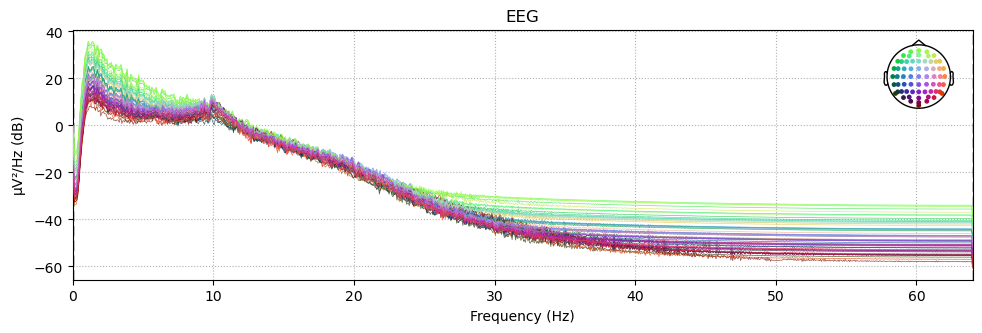

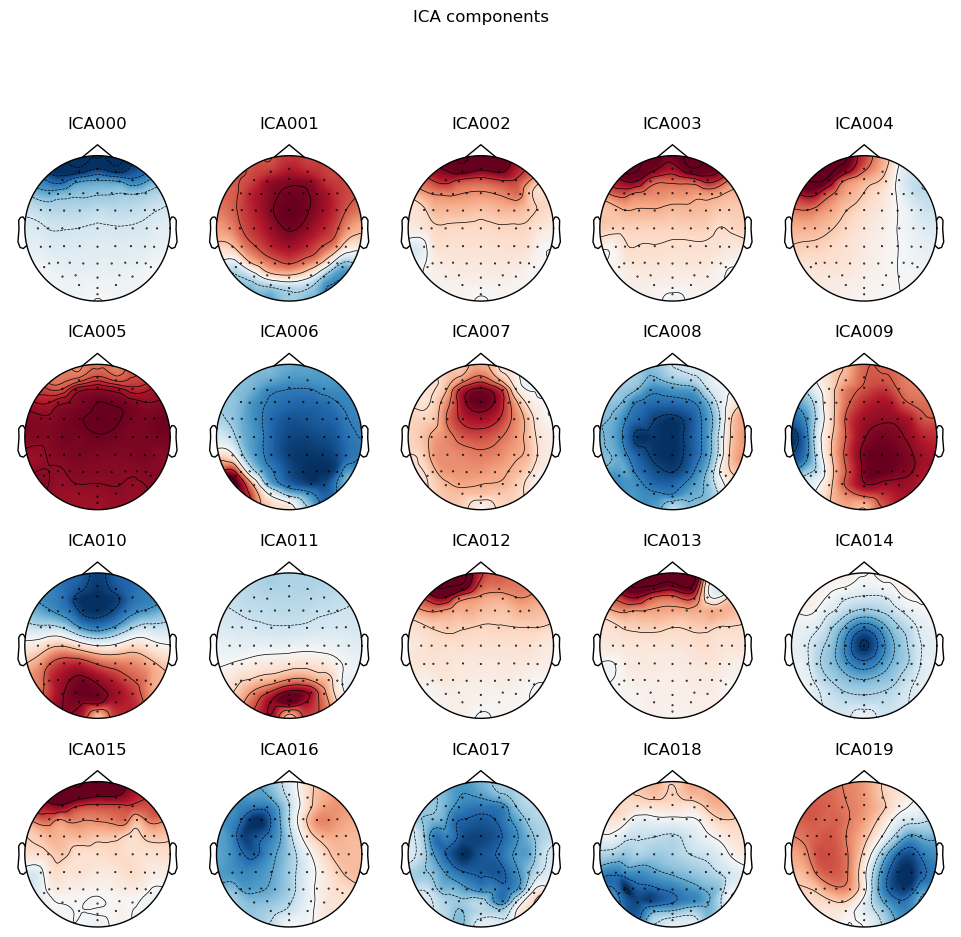

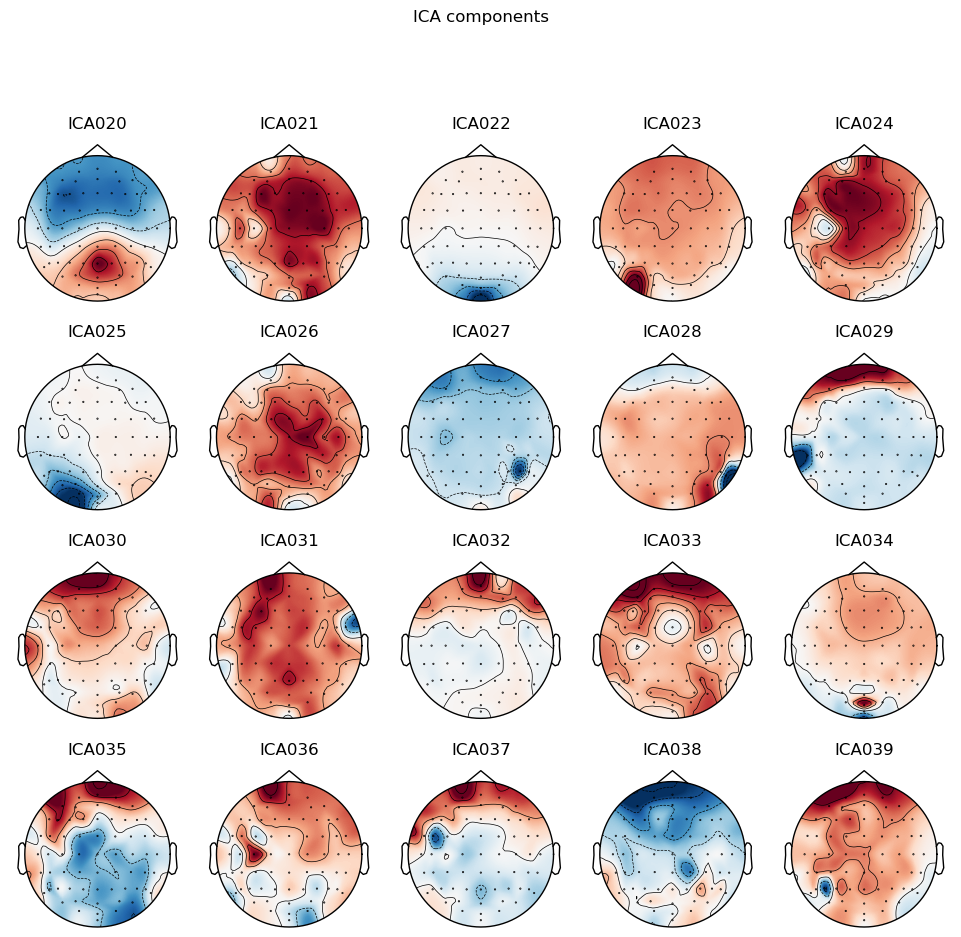

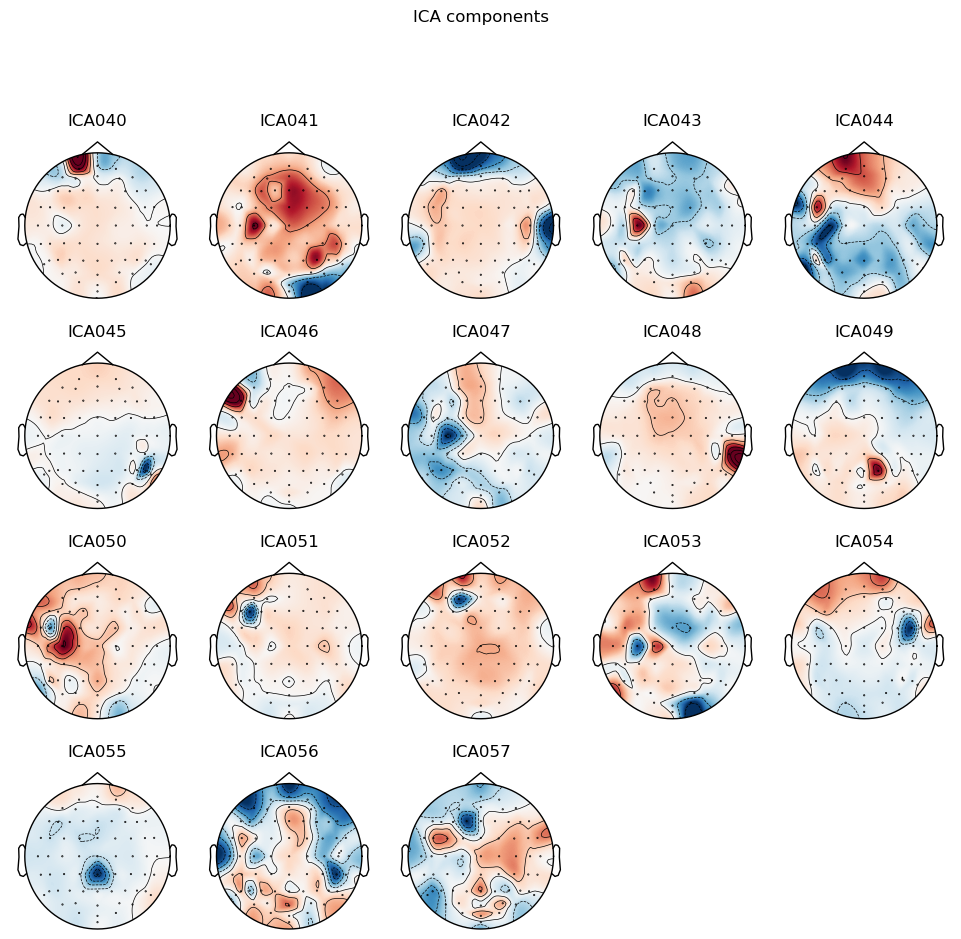

[<MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 18 Axes>]

In [60]:
ica = ICA(max_iter='auto', random_state=97, n_components=58)

ica.fit(raw)

ica.plot_components()

#ICA components over time
#ica.plot_sources(raw)

In [68]:
#exclude components based on correlation to eog
eog_indices, eog_scores = ica.find_bads_eog(raw)
ica.exclude = eog_indices

#manually select components if eog not available

#ica.exclude = [0, 1,2, 6,8]


#reconstruct raw
reconst_raw = raw.copy()
ica.apply(reconst_raw)

Using EOG channels: LO1, LO2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (58 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


<RawArray | 72 x 85120 (665.0 s), ~46.8 MB, data loaded>

## PLOTS

In [69]:
t_keystrokes = clean_triggers(events_arr[events_arr[:, 2]==2])
print(t_keystrokes.shape)
t_keystrokes = t_keystrokes[50:]
print(t_keystrokes.shape)

(328, 3)
(278, 3)


All keystroke ERPs

Not setting metadata
278 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 278 events and 129 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


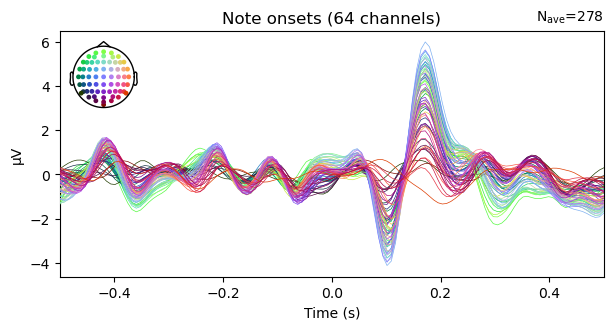

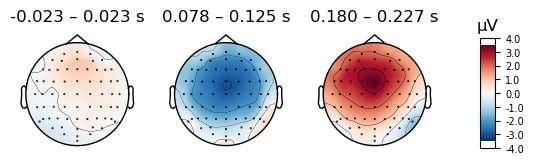

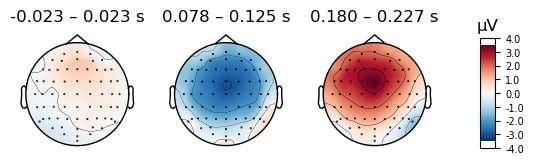

In [70]:
events_arr = make_raw_events(events_sv)
t_keystrokes = clean_triggers(events_arr[events_arr[:, 2]==2])
t_keystrokes = t_keystrokes[50:]
epochs = mne.Epochs(reconst_raw, t_keystrokes, tmin=erp_begin, tmax=erp_end, preload=True)
#fig = epochs.plot(events=t_keystrokes)
evoked = epochs.average()
evoked.plot(titles = f'Note onsets')

evoked.plot_topomap(times=[0,0.1, 0.2], average=0.05)

In [71]:
reject_criteria = dict(
    
    eeg=100e-6,  # 100 µV

)  # 100 µV
epochs.drop_bad(reject=reject_criteria)
print(epochs.drop_log)

    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'Fpz', 'Fp2', 'AF8', 'AFz']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FC6', 'FC4', 'FC2', 'FCz']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on

Not setting metadata
259 matching events found


No baseline correction applied
0 projection items activated
combining channels using "mean"


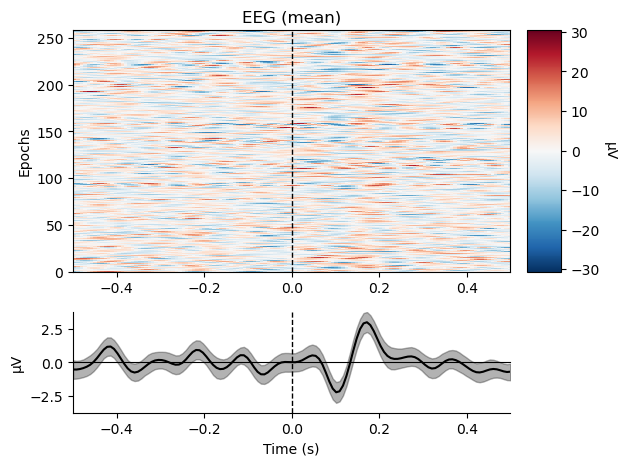

[<Figure size 640x480 with 3 Axes>]

In [72]:
mne.viz.plot_epochs_image(epochs, combine = 'mean')

In [73]:
evoked = evoked.copy().interpolate_bads(reset_bads = True)
epochs = epochs.copy().interpolate_bads(reset_bads = True)

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_42418/760160267.py:1: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  evoked = evoked.copy().interpolate_bads(reset_bads = True)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_42418/760160267.py:2: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  epochs = epochs.copy().interpolate_bads(reset_bads = True)


In [74]:
overwrite = False

mne.write_evokeds(f'{evokeds_folder}/{task}_ERP_{period}_{subject_ID}.fif', evoked, overwrite = overwrite)
epochs.save(f'{epochs_folder}/{task}_epochs_{period}_{subject_ID}.fif', overwrite = overwrite)


NameError: name 'subject_ID' is not defined